In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from IPython.display import clear_output
from sklearn.metrics import mean_squared_log_error, mean_squared_error

%matplotlib inline

In [ ]:
AGG_COLS = ["material_code", "company_code", "country", "region", "manager_code"]

In [ ]:
data = pd.read_csv("sc2021_train_deals.csv", parse_dates=["month", "date"])
data

,material_code,company_code,country,region,manager_code,month,material_lvl1_name,material_lvl2_name,material_lvl3_name,contract_type,date,volume
0,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-01,43.0
1,197,0,Китай,Китай,16350,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,95.0
2,794,2162,Казахстан,Атырауская обл.,10942,2018-01-01,Базовые полимеры,ПП,ПП,Контракт,2018-01-02,57.0
3,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,21.0
4,133,0,Китай,Китай,17745,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,150.0
...,...,...,...,...,...,...,...,...,...,...,...,...
92301,134,0,Украина,Украина,18156,2020-07-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2020-07-31,21.0
92302,486,0,Россия,Ростовская обл.,16156,2020-07-01,Базовые полимеры,ПП,ПП,Спот,2020-07-31,3.0
92303,276,7372,Польша,Польша,17029,2020-07-01,Базовые полимеры,ПП,ПП,Контракт,2020-07-31,25.0
92304,583,5983,Россия,Респ. Башкортостан,16788,2020-07-01,Пластики и продукты органического синтеза,ПСВ,Полистирол,Контракт,2020-07-31,21.0


In [ ]:
countries = data["country"].unique()
regions = data["region"].unique()
contracts = data["contract_type"].unique()
materials = data["material_code"].unique()
managers = data["manager_code"].unique()
companies = data["company_code"].unique()

nr_countries = countries.shape[0]
nr_contracts = contracts.shape[0]
nr_regions = regions.shape[0]
nr_materials = materials.shape[0]
nr_managers = managers.shape[0]
nr_companies = companies.shape[0]

print("Countries:", nr_countries)
print("Contracts:", nr_contracts)
print("Regions:", nr_regions)
print("Materials:", nr_materials)
print("Managers:", nr_managers)
print("Companies:", nr_companies)

Countries: 30
Contracts: 3
Regions: 102
Materials: 90
Managers: 59
Companies: 229


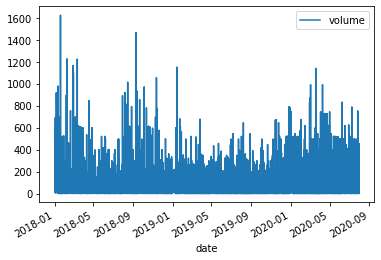

In [ ]:
data.plot(x = "date", y = "volume")

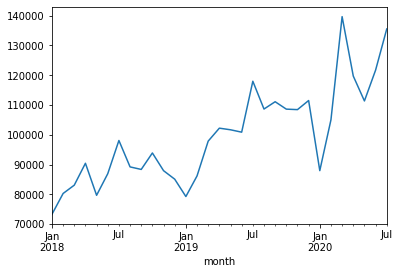

In [ ]:
data.groupby(["month"])["volume"].sum().plot(x = "month", y = "volume")

## General Feature Engineering

In [ ]:
def category_to_id(categories):
    id_to_category = list(categories)
    category_to_id = dict(zip(id_to_category, range(len(id_to_category))))
    return id_to_category, category_to_id

In [ ]:
id_to_country, country_to_id = category_to_id(countries)
id_to_region, region_to_id = category_to_id(regions)
id_to_company, company_to_id = category_to_id(companies)
id_to_material, material_to_id = category_to_id(materials)
id_to_manager, manager_to_id = category_to_id(managers)
id_to_contract, contract_to_id = category_to_id(contracts)

In [ ]:
data["m"] = data["date"].apply(lambda date: date.month)
data["d"] = data["date"].apply(lambda date: date.day)
data["y"] = data["date"].apply(lambda date: date.year)
data

,material_code,company_code,country,region,manager_code,month,material_lvl1_name,material_lvl2_name,material_lvl3_name,contract_type,date,volume,m,d,y
0,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-01,43.0,1,1,2018
1,197,0,Китай,Китай,16350,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,95.0,1,2,2018
2,794,2162,Казахстан,Атырауская обл.,10942,2018-01-01,Базовые полимеры,ПП,ПП,Контракт,2018-01-02,57.0,1,2,2018
3,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,21.0,1,2,2018
4,133,0,Китай,Китай,17745,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,150.0,1,2,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92301,134,0,Украина,Украина,18156,2020-07-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2020-07-31,21.0,7,31,2020
92302,486,0,Россия,Ростовская обл.,16156,2020-07-01,Базовые полимеры,ПП,ПП,Спот,2020-07-31,3.0,7,31,2020
92303,276,7372,Польша,Польша,17029,2020-07-01,Базовые полимеры,ПП,ПП,Контракт,2020-07-31,25.0,7,31,2020
92304,583,5983,Россия,Респ. Башкортостан,16788,2020-07-01,Пластики и продукты органического синтеза,ПСВ,Полистирол,Контракт,2020-07-31,21.0,7,31,2020


## LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.optimizers import Adamax
from keras import Model

### Feature Engineering

In [ ]:
group_ts = data.groupby(AGG_COLS + ["month"])["volume"].sum().unstack(fill_value=0).reset_index()

group_ts["country"] = group_ts["country"].apply(lambda country: country_to_id[country])
group_ts["region"] = group_ts["region"].apply(lambda region: region_to_id[region])
group_ts["material_code"] = group_ts["material_code"].apply(lambda material: material_to_id[material])
group_ts["manager_code"] = group_ts["manager_code"].apply(lambda manager: manager_to_id[manager])
group_ts["company_code"] = group_ts["company_code"].apply(lambda company: company_to_id[company])

# group_ts["contract_type"] = group_ts["contract_type"].apply(lambda contract: contract_to_id[contract])

group_ts

month,material_code,company_code,country,region,manager_code,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00
0,21,36,3,19,14,340.0,340.0,260.0,240.0,220.0,220.0,220.0,220.0,220.0,280.0,280.0,280.0,200.0,200.0,200.0,185.0,103.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,0,5,14,2,0.0,0.0,0.0,200.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,98.0,82.0,62.0,145.0,124.0,181.0,208.0,207.0,17.0,72.0,250.0,394.0,288.0,210.0,249.0
2,3,0,5,65,2,0.0,0.0,0.0,0.0,140.0,0.0,0.0,0.0,100.0,220.0,20.0,0.0,0.0,80.0,142.0,103.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,166.0,62.0,0.0,0.0
3,3,0,5,86,2,0.0,20.0,0.0,0.0,40.0,160.0,180.0,99.0,60.0,400.0,120.0,20.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,83.0,82.0,42.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,6.0
4,3,0,2,88,48,0.0,0.0,30.0,30.0,0.0,0.0,40.0,20.0,40.0,30.0,0.0,40.0,40.0,50.0,0.0,40.0,0.0,40.0,40.0,40.0,0.0,45.0,50.0,45.0,0.0,50.0,40.0,0.0,0.0,50.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,30,228,3,24,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,63.0,125.0,84.0,84.0,83.0
937,17,0,3,44,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,5.0,0.0,0.0,5.0,5.0,0.0,8.0,5.0,10.0,5.0,5.0,10.0,10.0,0.0,6.0,5.0,5.0,5.0,0.0,3.0,3.0,9.0
938,17,200,3,44,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,94.0,127.0,121.0,121.0,129.0,117.0,115.0,102.0,29.0,73.0,74.0,122.0,100.0,15.0,30.0,50.0
939,17,19,3,23,21,60.0,60.0,100.0,60.0,60.0,80.0,80.0,100.0,80.0,80.0,80.0,100.0,120.0,119.0,160.0,120.0,140.0,100.0,120.0,120.0,80.0,120.0,140.0,100.0,100.0,180.0,180.0,100.0,140.0,40.0,0.0


### Variables

In [ ]:
epochs = 100
learning_rate = 0.001
optimizer = Adamax(learning_rate = learning_rate)
cell_size = 8
train_set_size = 0.9

### Model

In [ ]:
keras.backend.clear_session()

## Context encoder

# Country encoder
country_in = Input(shape = (1, ), name = "country_in")
country_out = Embedding(input_dim = nr_countries + 1, output_dim = 10)(country_in)
country_out = Dense(10)(country_out)
country_out = Flatten()(country_out)

# Region encoder
region_in = Input(shape = (1, ), name = "region_in")
region_out = Embedding(input_dim = nr_regions + 1, output_dim = 10)(region_in)
region_out = Dense(10)(region_out)
region_out = Flatten()(region_out)

# Manager encoder
manager_in = Input(shape = (1, ), name = "manager_in")
manager_out = Embedding(input_dim = nr_managers + 1, output_dim = 10)(manager_in)
manager_out = Dense(10)(manager_out)
manager_out = Flatten()(manager_out)

# Material encoder
material_in = Input(shape = (1, ), name = "material_in")
material_out = Embedding(input_dim = nr_materials + 1, output_dim = 10)(material_in)
material_out = Dense(10)(material_out)
material_out = Flatten()(material_out)

# Company encoder
company_in = Input(shape = (1, ), name = "company_in")
company_out = Embedding(input_dim = nr_companies + 1, output_dim = 10)(company_in)
company_out = Dense(10)(company_out)
company_out = Flatten()(company_out)

# Merged features
merged_features = keras.layers.Concatenate()([country_out, region_out, manager_out, material_out, company_out])
merged_features = Dense(16, activation = "relu")(merged_features)
merged_features = Dense(cell_size, activation = "relu")(merged_features)

# Initial state
c_0 = Dense(cell_size, activation = "relu")(merged_features)

## Time series encoder
rnn_in = Input(shape = (None, 1), name = "rnn_in")
rnn_output = LSTM(cell_size, name = "rnn_1")(rnn_in, initial_state = [c_0, c_0])

# rnn_output = LSTM(cell_size, name = "rnn_2", return_sequences = True)(rnn_output)
# rnn_output = LSTM(cell_size, name = "rnn_3")(rnn_output)

# Regression decoder
prediction = Dense(cell_size, activation = "relu")(rnn_output)
prediction = Dense(32, activation = "relu")(prediction) # 16 is an alternative
prediction = Dense(1, activation = "relu")(prediction)

model = Model(inputs = [country_in, region_in, company_in, manager_in, material_in, rnn_in], outputs = prediction)
model.compile(loss = "mean_squared_logarithmic_error", optimizer = optimizer)

In [ ]:
prepared_data = group_ts.copy()

train_data = prepared_data.sample(frac=train_set_size,random_state=123)
test_data = prepared_data.drop(train_data.index)

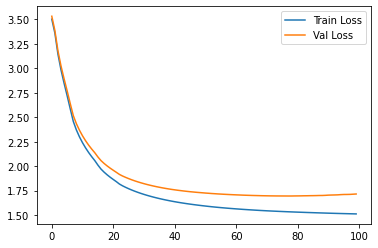

In [ ]:
# Inputs: [country_in, region_in, company_in, manager_in, material_in, contract_in, rnn_in]

metrics_df = pd.DataFrame()

for epoch in range(epochs):
    
    train_losses = []
    val_losses = []
    
    for month in range(1, 30):

        last_train_month = 5 + month
        months = train_data.iloc[:, 5:last_train_month].values.reshape(-1, month, 1)

        # print(months.shape)

        X = [
            train_data["country"].values,
            train_data["region"].values,
            train_data["company_code"].values,
            train_data["manager_code"].values,
            train_data["material_code"].values,
            train_data.iloc[:, 5:last_train_month].values.reshape(-1, month, 1)
        ]

        y = train_data.iloc[:, last_train_month]

        X_test = [
            test_data["country"].values,
            test_data["region"].values,
            test_data["company_code"].values,
            test_data["manager_code"].values,
            test_data["material_code"].values,
            test_data.iloc[:, 5:last_train_month].values.reshape(-1, month, 1) # Use 7 if 
        ]

        y_test = test_data.iloc[:, last_train_month]

        train_loss = model_simple.train_on_batch(x = X, y = y)
        val_loss = model_simple.test_on_batch(x = X_test, y = y_test)

        train_losses.append(np.sqrt(train_loss))
        val_losses.append(np.sqrt(val_loss))
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)

    metrics_df = metrics_df.append({"Train Loss": mean_train_loss, "Val Loss": mean_val_loss}, ignore_index = True)

    clear_output(True)
    metrics_df.plot()
    plt.show()

In [ ]:
model.save("simple_LSTM.keras")

In [ ]:
mappings ={
    "country": (id_to_country, country_to_id), 
    "region": (id_to_region, region_to_id), 
    "company": (id_to_company, company_to_id), 
    "material": (id_to_material, material_to_id), 
    "manager": (id_to_manager, manager_to_id), 
    "contract": (id_to_contract, contract_to_id)
}

np.save('mappings.npy', mappings)

In [ ]:
read_mappings = np.load('mappings.npy',allow_pickle='TRUE').item()

id_to_country, country_to_id = read_mappings["country"]
id_to_region, region_to_id = read_mappings["region"]
id_to_company, company_to_id = read_mappings["company"]
id_to_material, material_to_id = read_mappings["material"]
id_to_manager, manager_to_id = read_mappings["manager"]
id_to_contract, contract_to_id = read_mappings["contract"]

### Submission

In [ ]:
import pathlib
import pandas as pd
import tensorflow as tf
import keras

# MODEL_FILE = pathlib.Path(__file__).parent.joinpath("simple_LSTM.keras")
MODEL_FILE = "simple_LSTM.keras"
MAPPINGS_FILE = "mappings.npy"
AGG_COLS = ["material_code", "company_code", "country", "region", "manager_code"]

read_mappings = np.load(MAPPINGS_FILE,allow_pickle='TRUE').item()

id_to_country, country_to_id = read_mappings["country"]
id_to_region, region_to_id = read_mappings["region"]
id_to_company, company_to_id = read_mappings["company"]
id_to_material, material_to_id = read_mappings["material"]
id_to_manager, manager_to_id = read_mappings["manager"]

def get_features(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """Вычисление признаков для `month`."""

    pred_data = df.groupby(AGG_COLS + ["month"])["volume"].sum().unstack(fill_value=0).reset_index()

    # Removing future values
    end_period = month - pd.offsets.MonthBegin(1)
    pred_data = pred_data.loc[:, :end_period]

    pred_data["country"] = pred_data["country"].apply(lambda country: country_to_id[country])
    pred_data["region"] = pred_data["region"].apply(lambda region: region_to_id[region])
    pred_data["material_code"] = pred_data["material_code"].apply(lambda material: material_to_id[material])
    pred_data["manager_code"] = pred_data["manager_code"].apply(lambda manager: manager_to_id[manager])
    pred_data["company_code"] = pred_data["company_code"].apply(lambda company: company_to_id[company])

    month = pred_data.iloc[:, 5:].shape[1]

    X = [
        pred_data["country"].values,
        pred_data["region"].values,
        pred_data["company_code"].values,
        pred_data["manager_code"].values,
        pred_data["material_code"].values,
        pred_data.iloc[:, 5:].values.reshape(-1, month, 1)
    ]

    return pred_data, X


def predict(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """
    Вычисление предсказаний.

    Параметры:
        df:
          датафрейм, содержащий все сделки с начала тренировочного периода до `month`; типы
          колонок совпадают с типами в ноутбуке `[SC2021] Baseline`,
        month:
          месяц, для которого вычисляются предсказания.

    Результат:
        Датафрейм предсказаний для каждой группы, содержащий колонки:
            - `material_code`, `company_code`, `country`, `region`, `manager_code`,
            - `prediction`.
        Предсказанные значения находятся в колонке `prediction`.
    """

    pred_data, X = get_features(df, month)

    model = keras.models.load_model(MODEL_FILE)
    predictions = model.predict(x = X)

    preds_df = pred_data[AGG_COLS].copy()
    preds_df["prediction"] = predictions

    preds_df["country"] = preds_df["country"].apply(lambda country: id_to_country[country])
    preds_df["region"] = preds_df["region"].apply(lambda region: id_to_region[region])
    preds_df["material_code"] = preds_df["material_code"].apply(lambda material: id_to_material[material])
    preds_df["manager_code"] = preds_df["manager_code"].apply(lambda manager: id_to_manager[manager])
    preds_df["company_code"] = preds_df["company_code"].apply(lambda company: id_to_company[company])

    return preds_df

In [ ]:
month = pd.Timestamp(year=2020, month=1, day=1)
pred_df = predict(data.copy(), month)

true = group_ts[month]
pred = pred_df["prediction"]

np.sqrt(mean_squared_log_error(true, pred))

1.774611992032699

## Baseline model

In [ ]:
import pathlib
import pandas as pd
from catboost import CatBoostRegressor

MODEL_FILE = "baseline_model.cbm"
AGG_COLS = ["material_code", "company_code", "country", "region", "manager_code"]

def get_features(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """Вычисление признаков для `month`."""

    start_period = month - pd.offsets.MonthBegin(6)
    end_period = month - pd.offsets.MonthBegin(1)

    df = df.loc[:, :end_period]

    features = pd.DataFrame([], index=df.index)
    features["month"] = month.month
    features[[f"vol_tm{i}" for i in range(6, 0, -1)]] = df.loc[:, start_period:end_period].copy()

    rolling = df.rolling(12, axis=1, min_periods=1)
    features = features.join(rolling.mean().iloc[:, -1].rename("last_year_avg"))
    features = features.join(rolling.min().iloc[:, -1].rename("last_year_min"))
    features = features.join(rolling.max().iloc[:, -1].rename("last_year_max"))
    features["month"] = month.month

    return features.reset_index()


def predict(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """
    Вычисление предсказаний.

    Параметры:
        df:
          датафрейм, содержащий все сделки с начала тренировочного периода до `month`; типы
          колонок совпадают с типами в ноутбуке `[SC2021] Baseline`,
        month:
          месяц, для которого вычисляются предсказания.

    Результат:
        Датафрейм предсказаний для каждой группы, содержащий колонки:
            - `material_code`, `company_code`, `country`, `region`, `manager_code`,
            - `prediction`.
        Предсказанные значения находятся в колонке `prediction`.
    """

    group_ts = df.groupby(AGG_COLS + ["month"])["volume"].sum().unstack(fill_value=0)
    features = get_features(group_ts, month)

    model = CatBoostRegressor()
    model.load_model(MODEL_FILE)
    predictions = model.predict(features[model.feature_names_])

    preds_df = features[AGG_COLS].copy()
    preds_df["prediction"] = predictions
    return preds_df

In [ ]:
month = pd.Timestamp(year=2018, month=7, day=1)
get_features(data.groupby(AGG_COLS + ["month"])["volume"].sum().unstack(fill_value=0), month)

,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,last_year_min,last_year_max
0,124,7278,Россия,Респ. Татарстан,17460,7,340.0,340.0,260.0,240.0,220.0,220.0,270.000000,220.0,340.0
1,133,0,Белоруссия,Минская обл.,10942,7,0.0,0.0,0.0,200.0,60.0,0.0,43.333333,0.0,200.0
2,133,0,Белоруссия,Могилевская обл.,10942,7,0.0,0.0,0.0,0.0,140.0,0.0,23.333333,0.0,140.0
3,133,0,Белоруссия,г. Минск,10942,7,0.0,20.0,0.0,0.0,40.0,160.0,36.666667,0.0,160.0
4,133,0,Казахстан,г. Нур-Султан,13301,7,0.0,0.0,30.0,30.0,0.0,0.0,10.000000,0.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,986,9943,Россия,Смоленская обл.,17460,7,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
937,998,0,Россия,Ленинградская обл.,18079,7,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
938,998,3380,Россия,Ленинградская обл.,14956,7,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
939,998,5410,Россия,г. Санкт-Петербург,14956,7,60.0,60.0,100.0,60.0,60.0,80.0,70.000000,60.0,100.0


In [ ]:
month = pd.Timestamp(year=2020, month=1, day=1)
pred_df = predict(data.copy(), month)

true = group_ts[month]
pred = pred_df["prediction"]

np.sqrt(mean_squared_log_error(true, pred))

2.1658134707972563

## Time Cross Validation

In [ ]:
train_data = group_ts.copy()

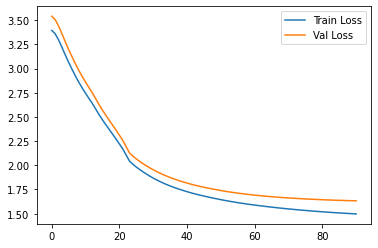

In [ ]:
# Inputs: [country_in, region_in, company_in, manager_in, material_in, contract_in, rnn_in]

metrics_df = pd.DataFrame()

for epoch in range(epochs): 
    
    train_losses = []
    val_losses = []
    
    for month in range(1, 19):

        last_train_month = 5 + month
        months = train_data.iloc[:, 5:last_train_month].values.reshape(-1, month, 1)

        # print(months.shape)

        X = [
            train_data["country"].values,
            train_data["region"].values,
            train_data["company_code"].values,
            train_data["manager_code"].values,
            train_data["material_code"].values,
            train_data.iloc[:, 5:last_train_month].values.reshape(-1, month, 1)
        ]

        y = train_data.iloc[:, last_train_month]

        # Validation loop over months with indices 21 till 30
        for index in range(1,13):
            X_test = [
                train_data["country"].values,
                train_data["region"].values,
                train_data["company_code"].values,
                train_data["manager_code"].values,
                train_data["material_code"].values,
                train_data.iloc[:, last_train_month:last_train_month + index].values.reshape(-1, index, 1)
            ]

            y_test = train_data.iloc[:, last_train_month + index]
            val_loss = model.test_on_batch(x = X_test, y = y_test)
            val_losses.append(np.sqrt(val_loss))

        train_loss = model.train_on_batch(x = X, y = y)
        train_losses.append(np.sqrt(train_loss))
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)

    metrics_df = metrics_df.append({"Train Loss": mean_train_loss, "Val Loss": mean_val_loss}, ignore_index = True)

    clear_output(True)
    metrics_df.plot()
    plt.show()

# Additional Data

In [ ]:
external = pd.read_csv("external.csv", parse_dates=["MONTH"])
external.head()

,MONTH,CLOSE,OPEN,HIGH,LOW,VALUE,CAPITALIZATION,INFECTIONS
0,2018-01-01,2264.502000,2255.580500,2272.608000,2243.146000,3.895239e+10,9.984019e+12,0.0
1,2018-02-01,2273.786842,2272.337895,2288.386842,2259.286316,4.580713e+10,1.002495e+13,0.0
2,2018-03-01,2287.331429,2288.319524,2300.063333,2272.549524,3.858052e+10,9.968712e+12,0.0
3,2018-04-01,2236.146364,2235.738636,2258.189545,2212.944091,5.711218e+10,9.641586e+12,0.0
4,2018-05-01,2313.150000,2314.580000,2325.841429,2303.190000,3.639398e+10,9.973605e+12,0.0


In [ ]:
external_std = pd.read_csv("external_std.csv", parse_dates=["MONTH"])
external_std.head()

,MONTH,CLOSE,VALUE,CAPITALIZATION,INFECTIONS
0,2018-01-01,-1.126514,-0.964295,-0.784842,-0.674221
1,2018-02-01,-1.110396,-0.719733,-0.774194,-0.674221
2,2018-03-01,-1.086882,-0.977562,-0.788824,-0.674221
3,2018-04-01,-1.175739,-0.316395,-0.873917,-0.674221
4,2018-05-01,-1.042061,-1.055573,-0.787551,-0.674221


In [ ]:
external.plot(x = "MONTH", y = "INFECTIONS")
external.plot(x = "MONTH", y = "CLOSE")
external.plot(x = "MONTH", y = "VALUE")

In [ ]:
epochs = 400
learning_rate = 0.0001
optimizer = Adamax(learning_rate = learning_rate)
cell_size = 8
train_set_size = 0.9

In [ ]:
keras.backend.clear_session()

## Context encoder

# Country encoder
country_in = Input(shape = (1, ), name = "country_in")
country_out = Embedding(input_dim = nr_countries + 1, output_dim = 10)(country_in)
country_out = Dense(10)(country_out)
country_out = Flatten()(country_out)

# Region encoder
region_in = Input(shape = (1, ), name = "region_in")
region_out = Embedding(input_dim = nr_regions + 1, output_dim = 10)(region_in)
region_out = Dense(10)(region_out)
region_out = Flatten()(region_out)

# Manager encoder
manager_in = Input(shape = (1, ), name = "manager_in")
manager_out = Embedding(input_dim = nr_managers + 1, output_dim = 10)(manager_in)
manager_out = Dense(10)(manager_out)
manager_out = Flatten()(manager_out)

# Material encoder
material_in = Input(shape = (1, ), name = "material_in")
material_out = Embedding(input_dim = nr_materials + 1, output_dim = 10)(material_in)
material_out = Dense(10)(material_out)
material_out = Flatten()(material_out)

# Company encoder
company_in = Input(shape = (1, ), name = "company_in")
company_out = Embedding(input_dim = nr_companies + 1, output_dim = 10)(company_in)
company_out = Dense(10)(company_out)
company_out = Flatten()(company_out)

# Merged features
merged_features = keras.layers.Concatenate()([country_out, region_out, manager_out, material_out, company_out])
merged_features = Dense(16, activation = "relu")(merged_features)
merged_features = Dense(cell_size, activation = "relu")(merged_features)

# Initial state
c_0 = Dense(cell_size, activation = "relu")(merged_features)

## Time series encoder
rnn_in = Input(shape = (None, 5), name = "rnn_in")
rnn_output = LSTM(cell_size, name = "rnn_1")(rnn_in, initial_state = [c_0, c_0])

# rnn_output = LSTM(cell_size, name = "rnn_2", return_sequences = True)(rnn_output)
# rnn_output = LSTM(cell_size, name = "rnn_3")(rnn_output)

# Regression decoder
prediction = Dense(cell_size, activation = "relu")(rnn_output)
prediction = Dense(16, activation = "relu")(prediction)
prediction = Dense(1, activation = "relu")(prediction)

model_external = Model(inputs = [country_in, region_in, company_in, manager_in, material_in, rnn_in], outputs = prediction)
model_external.compile(loss = "mean_squared_logarithmic_error", optimizer = optimizer)

In [ ]:
prepared_data = group_ts.copy()
train_data = prepared_data.sample(frac=train_set_size,random_state=123)
test_data = prepared_data.drop(train_data.index)

In [ ]:
volume_std = data["volume"].std()
volume_mean = data["volume"].mean()

In [ ]:
# Inputs: [country_in, region_in, company_in, manager_in, material_in, contract_in, rnn_in]

metrics_df = pd.DataFrame()

for epoch in range(epochs): 
    
    train_losses = []
    val_losses = []
    
    for month in range(1, 30):

        last_train_month = 5 + month
        months = train_data.iloc[:, 5:last_train_month].values.reshape(-1, month, 1)

        external_data = external_std.iloc[:month, 1:].values.reshape(-1, month, 4)

        # Concatenating RNN train input
        rnn_train_input = train_data.iloc[:, 5:last_train_month].values.reshape(-1, month, 1)
        rnn_train_input = (rnn_train_input - volume_mean) / volume_std # Normalization

        train_observations = rnn_train_input.shape[0]
        rnn_train_input = np.concatenate((rnn_train_input, np.repeat(external_data, train_observations, axis = 0)), axis = 2)

        idx = np.random.choice(train_observations, size=1, replace=True)

        X = [
            train_data["country"].values[idx],
            train_data["region"].values[idx],
            train_data["company_code"].values[idx],
            train_data["manager_code"].values[idx],
            train_data["material_code"].values[idx],
            rnn_train_input[idx]
        ]

        y = train_data.iloc[idx, last_train_month]

        # Concatenating RNN test input
        rnn_test_input = test_data.iloc[:, 5:last_train_month].values.reshape(-1, month, 1)
        rnn_test_input = (rnn_test_input - volume_mean) / volume_std # Normalization

        test_observations = rnn_test_input.shape[0]
        rnn_test_input = np.concatenate((rnn_test_input, np.repeat(external_data, test_observations, axis = 0)), axis = 2)

        X_test = [
            test_data["country"].values,
            test_data["region"].values,
            test_data["company_code"].values,
            test_data["manager_code"].values,
            test_data["material_code"].values,
            rnn_test_input
        ]

        y_test = test_data.iloc[:, last_train_month]

        train_loss = model_external.train_on_batch(x = X, y = y)
        val_loss = model_external.test_on_batch(x = X_test, y = y_test)

        train_losses.append(np.sqrt(train_loss))
        val_losses.append(np.sqrt(val_loss))
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)

    metrics_df = metrics_df.append({"Train Loss": mean_train_loss, "Val Loss": mean_val_loss}, ignore_index = True)

    clear_output(True)
    metrics_df.plot()
    plt.show()

In [ ]:
model_external.save("external_LSTM.keras")

## Submission External Model

In [ ]:
import pathlib
import pandas as pd
import tensorflow as tf
import keras

# MODEL_FILE = pathlib.Path(__file__).parent.joinpath("simple_LSTM.keras")
MODEL_FILE = "external_LSTM.keras"
MAPPINGS_FILE = "mappings.npy"
EXTERNAL_FILE = "external_std.csv"

AGG_COLS = ["material_code", "company_code", "country", "region", "manager_code"]

read_mappings = np.load(MAPPINGS_FILE,allow_pickle='TRUE').item()

id_to_country, country_to_id = read_mappings["country"]
id_to_region, region_to_id = read_mappings["region"]
id_to_company, company_to_id = read_mappings["company"]
id_to_material, material_to_id = read_mappings["material"]
id_to_manager, manager_to_id = read_mappings["manager"]

# Standardized external data
# 1. Monthly IMOEX values
# 2. Monthly COVID infections
external_std = pd.read_csv("external_std.csv", parse_dates=["MONTH"])

# Mean and standard deviation of volume of the whole dataset for standardization
volume_std = 46.95451613929162 
volume_mean = 33.490130652395294

def get_features(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """Вычисление признаков для `month`."""

    pred_data = df.groupby(AGG_COLS + ["month"])["volume"].sum().unstack(fill_value=0).reset_index()

    # Removing future values
    end_period = month - pd.offsets.MonthBegin(1)
    pred_data = pred_data.loc[:, :end_period]

    pred_data["country"] = pred_data["country"].apply(lambda country: country_to_id[country])
    pred_data["region"] = pred_data["region"].apply(lambda region: region_to_id[region])
    pred_data["material_code"] = pred_data["material_code"].apply(lambda material: material_to_id[material])
    pred_data["manager_code"] = pred_data["manager_code"].apply(lambda manager: manager_to_id[manager])
    pred_data["company_code"] = pred_data["company_code"].apply(lambda company: company_to_id[company])

    month = pred_data.iloc[:, 5:].shape[1]

    external_data = external_std.iloc[:month, 1:].values.reshape(-1, month, 4)

    # Concatenating RNN train input
    rnn_input = pred_data.iloc[:, 5:].values.reshape(-1, month, 1)
    rnn_input = (rnn_input - volume_mean) / volume_std # Normalization

    observations = rnn_input.shape[0]
    rnn_input = np.concatenate((rnn_input, np.repeat(external_data, observations, axis = 0)), axis = 2)

    X = [
        pred_data["country"].values,
        pred_data["region"].values,
        pred_data["company_code"].values,
        pred_data["manager_code"].values,
        pred_data["material_code"].values,
        rnn_input
    ]

    return pred_data, X


def predict(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """
    Вычисление предсказаний.

    Параметры:
        df:
          датафрейм, содержащий все сделки с начала тренировочного периода до `month`; типы
          колонок совпадают с типами в ноутбуке `[SC2021] Baseline`,
        month:
          месяц, для которого вычисляются предсказания.

    Результат:
        Датафрейм предсказаний для каждой группы, содержащий колонки:
            - `material_code`, `company_code`, `country`, `region`, `manager_code`,
            - `prediction`.
        Предсказанные значения находятся в колонке `prediction`.
    """

    pred_data, X = get_features(df, month)

    model = keras.models.load_model(MODEL_FILE)
    predictions = model.predict(x = X)

    preds_df = pred_data[AGG_COLS].copy()
    preds_df["prediction"] = predictions

    preds_df["country"] = preds_df["country"].apply(lambda country: id_to_country[country])
    preds_df["region"] = preds_df["region"].apply(lambda region: id_to_region[region])
    preds_df["material_code"] = preds_df["material_code"].apply(lambda material: id_to_material[material])
    preds_df["manager_code"] = preds_df["manager_code"].apply(lambda manager: id_to_manager[manager])
    preds_df["company_code"] = preds_df["company_code"].apply(lambda company: id_to_company[company])

    return preds_df

In [ ]:
month = pd.Timestamp(year=2020, month=1, day=1)
pred_df = predict(data.copy(), month)

true = group_ts[month]
pred = pred_df["prediction"]

np.sqrt(mean_squared_log_error(true, pred))

1.794985404972457